In [1]:
from matplotlib import pyplot as plt
import numpy as np
from train import load_datasets, create_inceptionv3_model, train_model
# autoreload
%load_ext autoreload
%autoreload 2

tensor([[[0.1922, 0.1922, 0.1922,  ..., 0.1216, 0.1216, 0.1216],
         [0.1922, 0.1922, 0.1922,  ..., 0.1216, 0.1216, 0.1216],
         [0.1922, 0.1922, 0.1922,  ..., 0.1137, 0.1137, 0.1137],
         ...,
         [0.1137, 0.1137, 0.0863,  ..., 0.0588, 0.0588, 0.0588],
         [0.1098, 0.1098, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0902, 0.0902, 0.0588,  ..., 0.0588, 0.0588, 0.0588]],

        [[0.9255, 0.9255, 0.9255,  ..., 1.0000, 1.0000, 1.0000],
         [0.9255, 0.9255, 0.9255,  ..., 1.0000, 1.0000, 1.0000],
         [0.9255, 0.9255, 0.9255,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.9255, 0.9255, 0.9373,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 0.9255,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.0549, 0.0549, 0.0549,  ..., 0.0471, 0.0471, 0.0471],
         [0.0549, 0.0549, 0.0549,  ..., 0.0471, 0.0471, 0.0471],
         [0.0549, 0.0549, 0.0549,  ..., 0.0510, 0.0510, 0.

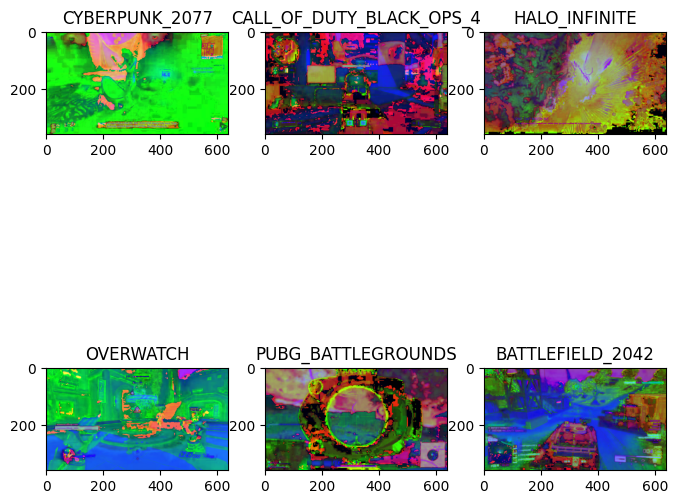

In [2]:
from torchvision import transforms as T
transform = T.Compose([
    T.Resize((320, 180)),
    T.ToTensor(),
    # T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.229, 0.224, 0.225]),
])

train_dataset, val_dataset, test_dataset = load_datasets("./dataset/processed", None)

# example
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 2
for i in range(1, cols * rows + 1):
    sample_idx = np.random.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    print(img)
    
    figure.add_subplot(rows, cols, i)
    plt.title(train_dataset.classes[label])
    plt.imshow(img.numpy().transpose(1,2,0))
plt.show()


In [36]:
import torch
from torchvision.models import efficientnet_b4

model = efficientnet_b4()
in_features = model.classifier[1].in_features
model.classifier[1] = torch.nn.Linear(in_features, len(train_dataset.classes))
output = model(torch.randn(1, 3, 320, 180))
print(output)


# model = create_inceptionv3_model(len(train_dataset.classes))
# outputs, _ = model(train_dataset[0][0].unsqueeze(0))
# print(outputs)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# start_epoch = 0

tensor([[-0.1170, -0.0518,  0.0041,  0.0023,  0.0204,  0.1410,  0.1520,  0.1782,
          0.0754,  0.0650, -0.0188,  0.0826, -0.0339, -0.0983,  0.1698,  0.1959,
         -0.0658, -0.1129, -0.1577,  0.0962,  0.2726,  0.0574,  0.1119, -0.2331,
          0.1196,  0.0566,  0.1588,  0.0460, -0.2164, -0.1273]],
       grad_fn=<AddmmBackward0>)


In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.2)
start_epoch = 0

In [28]:
# Load model if provided
from train import load_model
continue_training_from = None
if continue_training_from:
    model, optimizer, start_epoch = load_model(continue_training_from, model, optimizer)

In [38]:
from train import train_model, test_model, inceptionv3_predict_fix

train_model(
    model,
    train_dataset,
    num_epochs=10,
    cur_epoch=start_epoch,
    optimizer=optimizer,
    batch_size=16,
    limit_dataset_size=100,
    val_dataset=val_dataset,
    val_every=100,
    val_sample_size=300,
    # predict_fix=inceptionv3_predict_fix,
)
# test_inceptionv3(model, test_dataset, batch_size=1, limit_dataset_size=1000)

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
